Best Q in generation:  3033.3501389707667
Generation: 0
Best Q in generation:  2988.61460051432
Generation: 1
Best Q in generation:  2891.1040287312335
Generation: 2
Best Q in generation:  2891.1040287312335
Generation: 3
Best Q in generation:  2891.1040287312335
Generation: 4
Best Q in generation:  2891.1040287312335
Generation: 5
Best Q in generation:  2891.1040287312335
Generation: 6
Best Q in generation:  2891.1040287312335
Generation: 7
Best Q in generation:  2891.1040287312335
Generation: 8
Best Q in generation:  2891.1040287312335
Generation: 9
Best Q in generation:  2891.1040287312335
Generation: 10
Best Q in generation:  2891.1040287312335
Generation: 11
Best Q in generation:  2891.1040287312335
Best Q: 2891.1040287312335


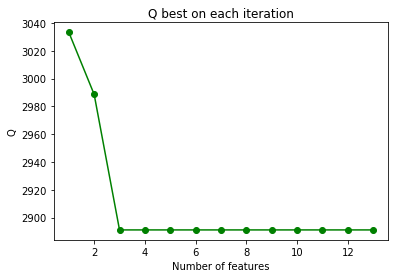

Features: SEX BMI BP S1 S2 S5 


In [2]:
import numpy as np
from sklearn import svm
from sklearn.linear_model import LinearRegression
import optunity.metrics as metrics
from sklearn.neural_network import MLPRegressor as mlpr
from pylab import rcParams
import pandas as pd
import data_preprocessor
import random
import copy
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib
import matplotlib.animation as animation
import matplotlib.patches as patches
from pylab import rcParams

class Q_Criterion:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        
        self.X_test = X_test
        self.y_test = y_test
        
    def get_list_of_indexes_by_bitmask(self, bitmask):
        ls = []
        for i in range(len(bitmask)):
            if bitmask[i] == 1:
                ls.append(i)
                
        return ls 
    
    def calc_Q(self, feature_bitmask):
        list_of_features = self.get_list_of_indexes_by_bitmask(feature_bitmask)
        
        model = LinearRegression()
        model.fit(self.X_train[:, list_of_features], self.y_train)
        
        y_hat = model.predict(self.X_test[:, list_of_features])
        Q = metrics.mse(y_hat, self.y_test)
        return Q
        
        
class GA:
    def __init__(self):
        return
    
    
    
    # -------------------------------------------------------------------------
    def draw(self, mode, data, additional_information = []):    
        output_plot = plt.figure(dpi = 40)
        
        output_subplot = output_plot.add_subplot(111, aspect = 'equal')
        
        area_for_arrows = 0.2
        a = (1.0-area_for_arrows)/len(data[0])
        border_width = a/10
 
        plt.text(0.4, 0.4, mode, size = 50, rotation = -10.0, color = 'white',
                 ha = "center", va = "center",
                 bbox = dict(boxstyle = "round",
                          ec = (0.1, 0.1, 0.1),
                          fc = (0.1, 0.1, 0.1)),
        )
        
        for k in range(len(data)):
            cur_col = 'black'
            if k == 1:
                cur_col = 'blue'
            if k == 2:
                cur_col = 'red'
            
            for i in range(len(data[k])):
                if len(additional_information) > 0:
                    if k == 0:
                        if additional_information[i] == 0:
                            cur_col = 'blue'
                        else:
                            cur_col = 'red'
                    
                
                output_subplot.add_patch(
                        patches.Rectangle(
                            (a*i+border_width, k*a+border_width),   # (x,y)
                            a-2*border_width,          # width
                            a-2*border_width,          # height
                            color = 'black',
                            alpha = data[k][i]
                        )
                    )
                            
                output_subplot.add_patch(
                        patches.Rectangle(
                            (a*i+border_width, k*a+border_width),   # (x,y)
                            a-2*border_width,          # width
                            a-2*border_width,          # height
                            color = cur_col,
                            fill = False,
                            linewidth = 4
                        )
                    )
                        
                if mode == 'Mutation':
                    output_subplot.add_patch(
                        patches.FancyArrowPatch(
                            (0.81, 1.5*a),
                            (0.81, a/2),
                            connectionstyle = 'arc3, rad = -0.7',
                            mutation_scale = 20,
                            color = 'green'
                        )
                    )
                        
                if mode == 'Crossover':
                    output_subplot.add_patch(
                        patches.FancyArrowPatch(
                            (0.81, 2.5*a),
                            (0.85, a/2),
                            connectionstyle = 'arc3, rad = -0.9',
                            mutation_scale = 20,
                            color = 'green'
                        )
                    )
                    
                    output_subplot.add_patch(
                        patches.FancyArrowPatch(
                            (0.81, 1.5*a),
                            (0.81, a/2),
                            connectionstyle = 'arc3, rad = -0.7',
                            mutation_scale = 20,
                            color = 'green'
                        )
                    )
                    
                
        output_plot.set_size_inches(18.5, 10.5, forward=True)
                
        output_plot.canvas.draw()           
        output_plot.show()

        plt.show()
        plt.draw_all()
            
    # -------------------------------------------------------------------------
    
    
    def draw_Q(self, Q):
        plt.plot(np.arange(1, len(Q)+1), Q, 'ro-', color = 'green', label = 'min Q')

        plt.xlabel('Number of features')
        plt.ylabel('Q')
        plt.title('Q best on each iteration')   
        
        plt.rcParams["figure.figsize"] = (12, 5)
        
        plt.show()
    
    # ------------------------------------------------------------------------- 
    
    
    
    def fit(self, X_train, y_train, q_criterion, d, B, T, p_m, visualization):
        self.X_train = X_train
        self.y_train = y_train
        self.d = d
        self.B = B
        self.T = T
        self.p_m = p_m
        
        rand_gen = random.Random()
        
        n = len(X_train[0])
        
        Q_best_history = []
        
        Q_best  = 1E9
        best_feature_subset = []
        t_sharp = 1
        
        R = []
        # init population
        for i in range(B):
            mask = rand_gen.randint(1, (2**n)-1)
            cur_bitmask = bin(mask)[2:].zfill(n)
            
            obj = []
            for k in range(len(cur_bitmask)):
                if cur_bitmask[k] == '0':
                    obj.append(0)
                else:
                    obj.append(1)
            
            R.append(obj)
        # ---------------------------------------------------------------------
        
        for t in range(T):
            Q = []
            for i in range(len(R)):
                Q.append(q_criterion.calc_Q(R[i]))
                
            R = [x for _,x in sorted(zip(Q, R))]
            
            Q = []
            for i in range(len(R)):
                Q.append(q_criterion.calc_Q(R[i]))
                
            if len(R) > B:
                R = copy.deepcopy(R[:B])
                
            print('Best Q in generation: ', Q[0])
                
            Q_best_history.append(Q[0])
            
            if Q[0] < Q_best:
                Q_best = copy.deepcopy(Q[0])
                t_sharp = t
                best_feature_subset = R[0]
                
            if t-t_sharp >= d:
                if visualization == True:
                    self.draw(mode = 'Answer', data = [best_feature_subset])
                    
                print('Best Q:', q_criterion.calc_Q(best_feature_subset))
                self.draw_Q(Q_best_history)
                return best_feature_subset
             
            cross_R = []
            
            for i in range(len(R)):
                for j in range(i+1, len(R)):
                    new_obj = []
                    additional_information = []
                    for k in range(n):
                        get_gene_from = rand_gen.randint(0, 1)
                        
                        if get_gene_from == 0:
                            gene = copy.deepcopy(R[i][k])
                            additional_information.append(0)
                        else:
                            gene = copy.deepcopy(R[j][k])
                            additional_information.append(1)
                            
                        new_obj.append(gene)
                        
                    cross_R.append(new_obj)
                    
                    if visualization == True:
                        self.draw(mode = 'Crossover', data = [new_obj, R[i], R[j]],
                                  additional_information = additional_information)
                         
            mut_R = []
                    
            for i in range(len(R)):
                obj = []
                additional_information = []
                for k in range(n):
                    leave_as_it_was = random.choices([1, 0], weights = [1-p_m, p_m], k = 1)
                    
                    if leave_as_it_was[0] == 1:
                        obj.append(R[i][k])
                        additional_information.append(1)
                    else:
                        obj.append(1-R[i][k])
                        additional_information.append(0)
                        
                mut_R.append(obj)
                
                if visualization == True:
                    self.draw(mode = 'Mutation', data = [obj, R[i]],
                              additional_information = additional_information)
                    
            R = copy.deepcopy(R + mut_R + cross_R)
                   
            print('Generation:', t)
            
            
        if visualization == True:
            self.draw(mode = 'Answer', data = [best_feature_subset])
            
        print('Best Q:', q_criterion.calc_Q(best_feature_subset))
        self.draw_Q(Q_best_history)
        return best_feature_subset
        
    # -------------------------------------------------------------------------
            
def print_feature_names(F, names_of_features):
    print('Features:', end = ' ')
    for i in range(len(F)):
        if F[i] == 1:
            print(names_of_features[i], end = ' ')
    print()
    
        
def main():
    dp = data_preprocessor.Data_Preprocessor()
    X_train, y_train, X_test, y_test, names_of_features = dp.Prepare_data('diabetes')
    
    q_criterion = Q_Criterion(X_train, y_train, X_test, y_test)
    
    ga = GA()
    F = ga.fit(X_train, y_train, q_criterion, d = 10, B = 10, T = 300, p_m = 0.1,
               visualization = False)    
    
    print_feature_names(F, names_of_features)
    
    
main()       